In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy
import pickle as pkl

import warnings
warnings.filterwarnings('ignore') 

/home/administrator/.local/lib/python3.8/site-packages/mne_features/mock_numba.py:12: UserWarning: Numba needs NumPy 1.20 or less. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [2]:
hparams = {
        "resample": 128.0,
        "fmin": 8.0,
        "fmax": 30.0,
        "ch_names": [   # exclude vin's channels ({FT9, FT10, PO9, PO10})
            "Fp1", "Fp2",
            "F7", "F3", "Fz", "F4", "F8",
            "FC5", "FC1", "FC2", "FC6",
            "T7", "C3", "Cz", "C4", "T8",
            "CP5", "CP1", "CP2", "CP6",
            "P7", "P3", "Pz", "P4", "P8",
            "O1", "Oz", "O2",
        ],
    }

In [3]:
with open("../data/beetl/PHY_001_040_BRD.pkl", mode="rb") as f:
    ds = pkl.load(f)
    ds_info = ds.description

In [4]:
ds_info

,subject,scenario,event,label,label_idx,trial,split
0,PHY_001,rest,Resting,rest,0,0,train
1,PHY_001,right_hand,Thinking,right_hand,2,0,train
2,PHY_001,rest,Resting,rest,0,0,train
3,PHY_001,left_hand,Thinking,left_hand,3,0,train
4,PHY_001,rest,Resting,rest,0,0,train
...,...,...,...,...,...,...,...
6293,PHY_040,rest,Resting,rest,0,5,train
6294,PHY_040,feet,Thinking,feet,1,5,train
6295,PHY_040,rest,Resting,rest,0,5,train
6296,PHY_040,rest,Resting,rest,0,5,train


In [5]:
epochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "PHY_001") & (ds_info["label"] == "left_hand")].index])

epochs.set_montage("standard_1020")

Number of events,69
Events,-1: 69
Time range,0.000 – 1.992 sec
Baseline,off


In [41]:
epochs.plot_psd_topomap()

RuntimeError: No plottable channel types found

In [42]:
X = list()
Y = list()
S = list()
for i in ds_info[ds_info["subject"].isin([f"PHY_{i:03d}" for i in range(1, 2)])].index:
    X.append(ds.datasets[i].windows.get_data())
    Y.extend(ds.datasets[i].y)
    S.extend([ds.datasets[i].description["subject"]] * len(ds.datasets[i].y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)
le = LabelEncoder()
S = le.fit_transform(S)

X = (X - X.mean(axis=-1, keepdims=True)) / X.std(axis=-1, keepdims=True)
X.shape

(477, 28, 256)

In [36]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

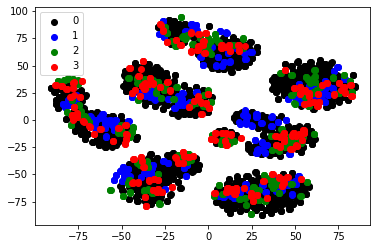

In [37]:
colors = "kbgrcmy"

fig = plt.Figure()
for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i])
    
plt.legend(np.unique(Y))

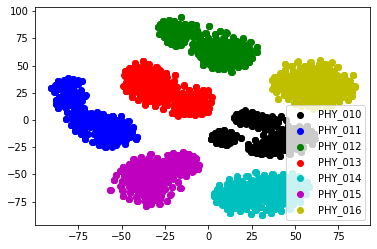

In [38]:
fig = plt.Figure()
for i, c in enumerate(np.unique(S)):
    idx = np.where(S == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i % len(colors)])
    
plt.legend(le.classes_)

In [21]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()
for i in ds_info[ds_info["subject"] == "PHY_016"].index:
    if ds.datasets[i].description["label"] == "rest":
        continue
    
    if ds.datasets[i].description["trial"] in {2, 5}:
        Xvalid.append(ds.datasets[i].windows.get_data() / 1e6)
        Yvalid.extend(ds.datasets[i].y)
    else:
        Xtrain.append(ds.datasets[i].windows.get_data() / 1e6)
        Ytrain.extend(ds.datasets[i].y)
        
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

In [29]:
clf = make_pipeline(
            Covariances("cov"),
            # FgMDM(metric=dict(mean="logeuclid", distance="logeuclid"), n_jobs=-1),
            TSclassifier(
                metric="logeuclid",
                clf=SVC(
                    C=1.0,
                    kernel="rbf",
                    # tol=1e-7,
                    max_iter=100000,
                    class_weight="balanced",
                    random_state=42,
                ),
                # clf=LinearDiscriminantAnalysis(
                #     solver="lsqr",
                #     shrinkage="auto",
                #     n_components=None,
                #     # tol=1e-7,
                #     covariance_estimator=None,
                # ),
            ),
        )

clf.fit(Xtrain, Ytrain)

Ypred = clf.predict(Xvalid)

print(metrics.balanced_accuracy_score(Yvalid, Ypred))
print(metrics.confusion_matrix(Yvalid, Ypred))

0.25595238095238093
[[ 9  9  3]
 [16  7  1]
 [19  1  1]]


In [119]:
csp = mne.decoding.CSP(n_components=28, reg=None, log=None, rank="full", transform_into='csp_space')

Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
Xvalid_csp = csp.transform(Xvalid)

Xtrain_csp.shape

(135, 28, 256)

In [120]:
bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
# bands = [(8,12), (10,14), (14,18), (18,22), (22,26), (26,30)]
# bands = [(4,8), (8,12), (12,16), (16,20), (20,24), (24,28), (28,32), (32,36)]

params = dict({
    'pow_freq_bands__log': True,
    'pow_freq_bands__normalize': False,
    'pow_freq_bands__freq_bands': bands,
})

fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

Xtrain_bp = fe.fit_transform(Xtrain)
Xvalid_bp = fe.transform(Xvalid)

clf = SVC(
    C=0.1,
    kernel="rbf",
    # tol=1e-7,
    max_iter=100000,
    class_weight="balanced",
    random_state=42,
)
# clf=LinearDiscriminantAnalysis(
#     solver="lsqr",
#     shrinkage="auto",
#     n_components=None,
#     # tol=1e-7,
#     covariance_estimator=None,
# )

clf.fit(Xtrain_bp, Ytrain)

Ypred = clf.predict(Xvalid_bp)
acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
    
print(f"nc: 0 - acc: {acc}")
print(metrics.confusion_matrix(Yvalid, Ypred))

for nc in range(1, 29):
    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

    Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
    Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])

    # ------------csv--------------
    clf = SVC(
        C=0.1,
        kernel="rbf",
        # tol=1e-7,
        max_iter=100000,
        class_weight="balanced",
        random_state=42,
    )
    # clf=LinearDiscriminantAnalysis(
    #     solver="lsqr",
    #     shrinkage="auto",
    #     n_components=None,
    #     # tol=1e-7,
    #     covariance_estimator=None,
    # )

    clf.fit(Xtrain_bp, Ytrain)

    Ypred = clf.predict(Xvalid_bp)
    acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
    
    print(f"nc: {nc} - acc: {acc}")
    print(metrics.confusion_matrix(Yvalid, Ypred))

nc: 0 - acc: 0.3333333333333333
[[ 0  0 21]
 [ 0  0 24]
 [ 0  0 21]]
nc: 1 - acc: 0.2857142857142857
[[18  0  3]
 [24  0  0]
 [21  0  0]]
nc: 2 - acc: 0.2857142857142857
[[18  0  3]
 [24  0  0]
 [21  0  0]]
nc: 3 - acc: 0.31746031746031744
[[19  0  2]
 [24  0  0]
 [20  0  1]]
nc: 4 - acc: 0.31746031746031744
[[19  0  2]
 [24  0  0]
 [20  0  1]]
nc: 5 - acc: 0.31746031746031744
[[19  0  2]
 [24  0  0]
 [20  0  1]]
nc: 6 - acc: 0.31746031746031744
[[19  0  2]
 [24  0  0]
 [20  0  1]]
nc: 7 - acc: 0.2857142857142857
[[16  0  5]
 [24  0  0]
 [19  0  2]]
nc: 8 - acc: 0.25396825396825395
[[14  0  7]
 [24  0  0]
 [19  0  2]]
nc: 9 - acc: 0.2857142857142857
[[16  0  5]
 [24  0  0]
 [19  0  2]]
nc: 10 - acc: 0.28571428571428575
[[15  0  6]
 [24  0  0]
 [18  0  3]]
nc: 11 - acc: 0.25396825396825395
[[14  0  7]
 [23  0  1]
 [19  0  2]]
nc: 12 - acc: 0.22222222222222224
[[11  0 10]
 [23  0  1]
 [18  0  3]]
nc: 13 - acc: 0.2222222222222222
[[10  0 11]
 [23  0  1]
 [17  0  4]]
nc: 14 - acc: 0.238095